In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00560_me_sa_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00949_pi_sa_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00177_gl_sa_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00799_pi_ax_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00705_pi_ax_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00510_me_sa_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00180_gl_sa_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00061_gl_ax_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_00551_me_sa_t1.jpg
/kaggle/input/brisc2025/brisc2025/segmentation_task/test/images/brisc2025_test_01000_pi_sa_t1.jpg
/kaggle/input/brisc2

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Using MirroredStrategy with {len(gpus)} GPUs")
elif len(gpus) == 1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print("Using single GPU")
else:
    strategy = tf.distribute.get_strategy()  # CPU or TPU fallback
    print("Using default strategy (CPU/TPU)")

print("Number of replicas:", strategy.num_replicas_in_sync)


2025-09-03 22:04:39.810564: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756937079.990350      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756937080.042801      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using MirroredStrategy with 2 GPUs
Number of replicas: 2


I0000 00:00:1756937092.493483      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756937092.494205      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# seed

In [3]:
import tensorflow as tf
import numpy as np
import random
import os

# Global random seed
SEED = 42

# Ensure reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


# ====== STEP 1: Imports & Accelerator Setup ======

In [4]:
# ====== STEP 1: Imports & Accelerator Setup ======
import os, random
import numpy as np
import tensorflow as tf

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Detect GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

if len(gpus) > 1:
    # Use all available GPUs (works if you have 2×T4)
    strategy = tf.distribute.MirroredStrategy()
    print("Using MirroredStrategy with", strategy.num_replicas_in_sync, "GPUs")
elif len(gpus) == 1:
    # Single GPU (P100 or T4)
    strategy = tf.distribute.get_strategy()
    print("Using single GPU strategy")
else:
    # CPU fallback
    strategy = tf.distribute.get_strategy()
    print("No GPU detected, using CPU")

print("Number of replicas:", strategy.num_replicas_in_sync)

# ====== STEP 2: Dataset Paths ======
DATA_ROOT = "/kaggle/input/brisc2025/brisc2025"

# Segmentation task
SEG_TRAIN = os.path.join(DATA_ROOT, "segmentation_task/train")
SEG_TEST  = os.path.join(DATA_ROOT, "segmentation_task/test")

# Classification task
CLS_TRAIN = os.path.join(DATA_ROOT, "classification_task/train")
CLS_TEST  = os.path.join(DATA_ROOT, "classification_task/test")

print("Segmentation train:", SEG_TRAIN)
print("Classification train:", CLS_TRAIN)

# ====== STEP 3: Image Settings ======
IMG_SIZE = (256, 256)   # resize all images
BATCH_SIZE = 16 * strategy.num_replicas_in_sync  # scale batch size with GPUs


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using MirroredStrategy with 2 GPUs
Number of replicas: 2
Segmentation train: /kaggle/input/brisc2025/brisc2025/segmentation_task/train
Classification train: /kaggle/input/brisc2025/brisc2025/classification_task/train


In [5]:
import numpy as np
import cv2
import os

# Pick a few mask files
mask_dir = os.path.join(SEG_TRAIN, "masks")  # adjust if needed
sample_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir)[:5]]

for f in sample_files:
    mask = cv2.imread(f, cv2.IMREAD_UNCHANGED)  # keep original values
    unique_vals = np.unique(mask)
    print(f, "unique values:", unique_vals)


/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_04333_pi_co_t1.png unique values: [  0   1   2   3   4   5 249 250 251 252 253 254 255]
/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_04935_pi_sa_t1.png unique values: [  0   1   2   3   4   5   6 249 250 251 252 253 254 255]
/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_01035_gl_sa_t1.png unique values: [  0   1   2   3   4   5   6   7 250 251 252 253 254 255]
/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_01066_gl_sa_t1.png unique values: [  0   1   2   3   4   5   6   7 249 250 251 252 253 254 255]
/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_04280_pi_co_t1.png unique values: [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]


In [6]:
import os
import numpy as np
import tensorflow as tf

mask_dir = "/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks"

all_unique = set()

for fname in os.listdir(mask_dir):
    if fname.endswith(".png"):
        mask_path = os.path.join(mask_dir, fname)
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1).numpy()
        unique_vals = np.unique(mask)
        all_unique.update(unique_vals.tolist())

print("All unique values across masks:", sorted(all_unique))
print("Total number of unique classes:", len(all_unique))


All unique values across masks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255]
Total number of unique classes: 21


# Step 2 ====== SEGMENTATION DATASET PIPELINE ======

In [7]:
# ====== SEGMENTATION DATASET PIPELINE ======
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

IMG_SIZE = (256, 256)
BATCH_SIZE = 16 * strategy.num_replicas_in_sync  # scale with GPUs
AUTOTUNE = tf.data.AUTOTUNE

# --- Helper to load dataset paths ---
def load_segmentation_dataset(image_dir, mask_dir):
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_paths  = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    print(f"Found {len(image_paths)} images and {len(mask_paths)} masks in {image_dir}")
    return image_paths, mask_paths

# --- Preprocess function ---
def parse_image_mask(img_path, mask_path):
    # Image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    # Mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)
    mask = tf.clip_by_value(mask, 0, 9)   # adjust if you want 10 classes max

    return img, mask

# --- Dataset builder ---
def make_segmentation_dataset(img_paths, mask_paths, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if shuffle:
        ds = ds.shuffle(len(img_paths), seed=42)
    ds = ds.map(parse_image_mask, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

# --- Paths ---
SEG_TRAIN_IMG = os.path.join(SEG_TRAIN, "images")
SEG_TRAIN_MASK = os.path.join(SEG_TRAIN, "masks")
SEG_TEST_IMG = os.path.join(SEG_TEST, "images")
SEG_TEST_MASK = os.path.join(SEG_TEST, "masks")

train_imgs, train_masks = load_segmentation_dataset(SEG_TRAIN_IMG, SEG_TRAIN_MASK)
test_imgs, test_masks   = load_segmentation_dataset(SEG_TEST_IMG, SEG_TEST_MASK)

# --- Split train into train/val ---
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_imgs, train_masks, test_size=0.2, random_state=42
)

# --- Build datasets (with clear names) ---
seg_train_ds = make_segmentation_dataset(train_imgs, train_masks, shuffle=True)
seg_val_ds   = make_segmentation_dataset(val_imgs, val_masks, shuffle=False)
seg_test_ds  = make_segmentation_dataset(test_imgs, test_masks, shuffle=False)

print("✅ Segmentation datasets ready:")
print("Train batches:", seg_train_ds)
print("Val batches:  ", seg_val_ds)
print("Test batches: ", seg_test_ds)


Found 3933 images and 3933 masks in /kaggle/input/brisc2025/brisc2025/segmentation_task/train/images
Found 860 images and 860 masks in /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images
✅ Segmentation datasets ready:
Train batches: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))>
Val batches:   <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))>
Test batches:  <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))>


# Step -3 Build train and test datasets

In [8]:
# ====== STEP 3: Build train, val, and test datasets ======
from sklearn.model_selection import train_test_split

# --- Define paths ---
SEG_TRAIN_IMG  = os.path.join(SEG_TRAIN, "images")
SEG_TRAIN_MASK = os.path.join(SEG_TRAIN, "masks")
SEG_TEST_IMG   = os.path.join(SEG_TEST, "images")
SEG_TEST_MASK  = os.path.join(SEG_TEST, "masks")

# --- Load file paths ---
train_imgs, train_masks = load_segmentation_dataset(SEG_TRAIN_IMG, SEG_TRAIN_MASK)
test_imgs,  test_masks  = load_segmentation_dataset(SEG_TEST_IMG, SEG_TEST_MASK)

# --- Split training set into Train + Validation ---
train_imgs_split, val_imgs_split, train_masks_split, val_masks_split = train_test_split(
    train_imgs, train_masks, test_size=0.2, random_state=42
)

# --- Build datasets ---
train_ds = make_segmentation_dataset(train_imgs_split, train_masks_split, shuffle=True)
val_ds   = make_segmentation_dataset(val_imgs_split, val_masks_split, shuffle=False)
test_ds  = make_segmentation_dataset(test_imgs, test_masks, shuffle=False)

# --- Debug info ---
print(f"Train samples: {len(train_imgs_split)}")
print(f"Validation samples: {len(val_imgs_split)}")
print(f"Test samples: {len(test_imgs)}")


Found 3933 images and 3933 masks in /kaggle/input/brisc2025/brisc2025/segmentation_task/train/images
Found 860 images and 860 masks in /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images
Train samples: 3146
Validation samples: 787
Test samples: 860


In [9]:
#ignore 
# --- Build train and test datasets ---
SEG_TRAIN_IMG = os.path.join(SEG_TRAIN, "images")
SEG_TRAIN_MASK = os.path.join(SEG_TRAIN, "masks")
SEG_TEST_IMG  = os.path.join(SEG_TEST, "images")
SEG_TEST_MASK = os.path.join(SEG_TEST, "masks")

train_imgs, train_masks = load_segmentation_dataset(SEG_TRAIN_IMG, SEG_TRAIN_MASK)
test_imgs, test_masks   = load_segmentation_dataset(SEG_TEST_IMG, SEG_TEST_MASK)

train_ds = make_segmentation_dataset(train_imgs, train_masks, shuffle=True)
test_ds  = make_segmentation_dataset(test_imgs, test_masks, shuffle=False)

print(train_ds, test_ds)



Found 3933 images and 3933 masks in /kaggle/input/brisc2025/brisc2025/segmentation_task/train/images
Found 860 images and 860 masks in /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.int32, name=None))>


In [10]:
#optional
all_unique_vals = set()
for _, masks in train_ds.take(-1):  # go through all batches
    unique_vals = tf.unique(tf.reshape(masks, [-1]))[0].numpy()
    all_unique_vals.update(unique_vals.tolist())

print("All unique mask values in training set:", sorted(all_unique_vals))

All unique mask values in training set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
#optional 
# Check unique mask values in training set
for _, masks in train_ds.take(1):
    unique_vals = tf.unique(tf.reshape(masks, [-1]))[0].numpy()
    print("Unique mask values in a sample batch:", sorted(unique_vals.tolist()))


Unique mask values in a sample batch: [0, 1, 2, 3, 4, 5, 6, 7, 9]


# Step 4 ====== CLASSIFICATION DATASET PIPELINE ======

Classes: ['pituitary', 'no_tumor', 'meningioma', 'glioma']
Unique patients in dataset: 5000
Train patients: 3200
Val patients: 800
Test patients: 1000
Overlap between sets: ✅ None

✅ Patient-wise classification dataset pipeline built successfully with no leakage!

Class distribution:
            Train  Val  Test
label                       
glioma        753  171   223
meningioma    844  213   272
no_tumor      699  178   190
pituitary     904  238   315


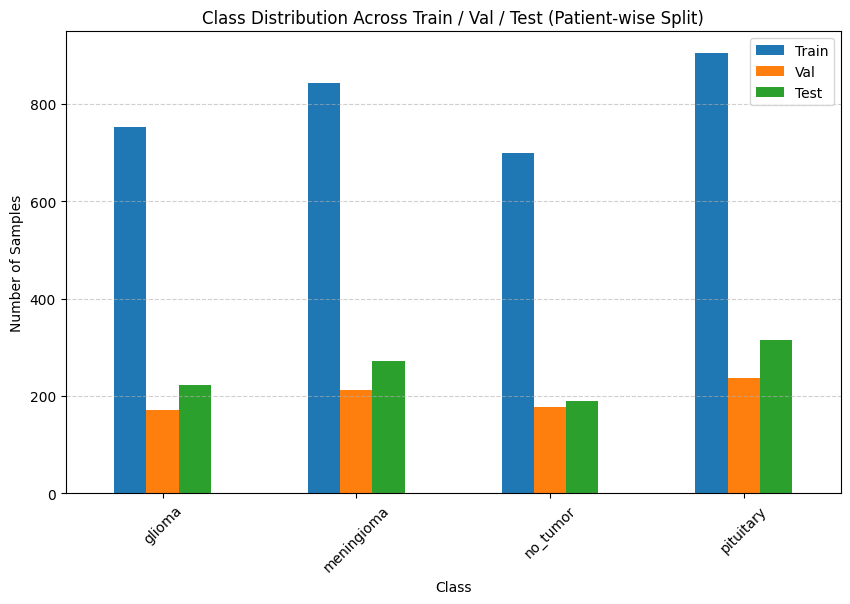

In [12]:
# ====== STEP 4: CLASSIFICATION DATASET PIPELINE (Patient-wise split, No Leakage) ======

import os, re
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# --- Settings ---
CLASSIFICATION_PATH = "/kaggle/input/brisc2025/brisc2025/classification_task"
IMG_SIZE = (224,224)   # classification uses smaller images
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# --- Load dataset paths ---
records = []
for label in os.listdir(os.path.join(CLASSIFICATION_PATH, "train")):  # all classes inside /train
    class_dir = os.path.join(CLASSIFICATION_PATH, "train", label)
    for fname in os.listdir(class_dir):
        # ✅ Extract patient ID from filename (numeric part between underscores)
        match = re.search(r'_(\d+)_', fname)
        patient_id = match.group(1) if match else fname
        records.append((os.path.join(class_dir, fname), label, patient_id))

df = pd.DataFrame(records, columns=["filepath", "label", "patient_id"])

# --- Encode labels ---
df["label_id"] = df["label"].astype("category").cat.codes
class_names = list(df["label"].unique())
num_classes = len(class_names)
print("Classes:", class_names)
print("Unique patients in dataset:", len(df["patient_id"].unique()))

# --- Patient-wise Split (train/val/test) ---
unique_patients = df["patient_id"].unique()

train_ids, test_ids = train_test_split(unique_patients, test_size=0.2, random_state=42)
train_ids, val_ids  = train_test_split(train_ids, test_size=0.2, random_state=42)

train_df = df[df["patient_id"].isin(train_ids)]
val_df   = df[df["patient_id"].isin(val_ids)]
test_df  = df[df["patient_id"].isin(test_ids)]

print(f"Train patients: {len(train_ids)}")
print(f"Val patients: {len(val_ids)}")
print(f"Test patients: {len(test_ids)}")

# --- Sanity check for leakage ---
overlap = set(train_df["patient_id"]).intersection(set(val_df["patient_id"])) \
        | set(train_df["patient_id"]).intersection(set(test_df["patient_id"])) \
        | set(val_df["patient_id"]).intersection(set(test_df["patient_id"]))
print("Overlap between sets:", overlap if overlap else "✅ None")

# --- Preprocessing Function ---
def preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def make_ds(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df["filepath"].values, df["label_id"].values))
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000, seed=42)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- Final Datasets ---
train_cls_ds = make_ds(train_df, shuffle=True)
val_cls_ds   = make_ds(val_df, shuffle=False)
test_cls_ds  = make_ds(test_df, shuffle=False)

print("\n✅ Patient-wise classification dataset pipeline built successfully with no leakage!")

# --- Class Distribution Check ---
train_counts = train_df["label"].value_counts()
val_counts   = val_df["label"].value_counts()
test_counts  = test_df["label"].value_counts()

# Combine into a single dataframe
counts_df = pd.DataFrame({
    "Train": train_counts,
    "Val": val_counts,
    "Test": test_counts
}).fillna(0).astype(int)

print("\nClass distribution:")
print(counts_df)

# --- Plot bar chart ---
counts_df.plot(kind="bar", figsize=(10,6))
plt.title("Class Distribution Across Train / Val / Test (Patient-wise Split)")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


# Step - 5 Define U-Net Model (baseline version)

In [13]:
# ====== STEP 5: U-NET MODEL (MULTICLASS VERSION) ======
from tensorflow.keras import layers, models

NUM_CLASSES = 10   # since masks have values 0..9

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.UpSampling2D((2,2))(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(256,256,3), num_classes=NUM_CLASSES):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Multiclass output
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(d4)

    return models.Model(inputs, outputs, name="U-Net-MultiClass")

# --- Build the model ---
with strategy.scope():
    unet_model = build_unet(input_shape=(256,256,3), num_classes=NUM_CLASSES)
    unet_model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # ✅ multiclass loss
        metrics=["accuracy"]
    )

unet_model.summary()


Model: "U-Net-MultiClass"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,403,082 (119.79 MB)

 Trainable params: 31,391,306 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Step 6 Training Setup (with Multi-GPU)

In [14]:
# ====== TRAINING (multi-class segmentation) ======
with strategy.scope():   # ensures multi-GPU works
    unet_model = build_unet(input_shape=(256,256,3))
    unet_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="sparse_categorical_crossentropy",   # <-- multi-class
        metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=10)]  # <-- 10 classes
    )

unet_model.summary()


Model: "U-Net-MultiClass"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ re_lu_18[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ re_lu_19[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ re_lu_20[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ re_lu_21[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,403,082 (119.79 MB)

 Trainable params: 31,391,306 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Step 7 Train Model

In [15]:
# Step 7 ====== Train U-Net Model ======
from tensorflow.keras import optimizers

# ✅ Make sure U-Net expects (256,256,3)
unet_model = build_unet(input_shape=(256,256,3))
unet_model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",   # multi-class segmentation
    metrics=["accuracy"]
)

# --- Callbacks ---
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "unet_seg_best.weights.h5",
    save_best_only=True,
    save_weights_only=True,
    monitor="val_loss",
    mode="min"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

# --- Safety check (detect wrong dataset accidentally used) ---
for sample_imgs, _ in seg_train_ds.take(1):
    if sample_imgs.shape[1:3] != (256,256):
        raise ValueError(
            f"🚨 Dataset shape mismatch! U-Net expects (256,256,3) "
            f"but got {sample_imgs.shape[1:]}.\n"
            f"Make sure you are using seg_train_ds / seg_val_ds, not classification datasets."
        )

# --- Fit U-Net ---
history = unet_model.fit(
    seg_train_ds,
    validation_data=seg_val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)

print("✅ Training finished. Best model weights saved as unet_seg_best.weights.h5")


Epoch 1/30


I0000 00:00:1756937159.365511      62 service.cc:148] XLA service 0x7cc74c0a2c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756937159.366373      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756937159.366395      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1756937160.408211      62 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1756937161.053792      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-03 22:06:08.288669: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,128,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targ

98/99 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.7213 - loss: 1.3972

W0000 00:00:1756937440.816779      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1756937461.484830      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756937461.790489      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756937470.139182      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756937470.370205      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7230 - loss: 1.3931

W0000 00:00:1756937497.787909      64 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1756937513.236829      65 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


99/99 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.7248 - loss: 1.3892 - val_accuracy: 0.9815 - val_loss: 1.4840
Epoch 2/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9810 - loss: 0.6157 - val_accuracy: 0.9815 - val_loss: 0.7598
Epoch 3/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9855 - loss: 0.4514 - val_accuracy: 0.9759 - val_loss: 0.6351
Epoch 4/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9856 - loss: 0.3677 - val_accuracy: 0.9820 - val_loss: 0.3464
Epoch 5/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9884 - loss: 0.2747 - val_accuracy: 0.9839 - val_loss: 0.2683
Epoch 6/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9889 - loss: 0.2211 - val_accuracy: 0.9872 - val_loss: 0.2080
Epoch 7/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9901 - loss: 0.1797 - val_accuracy: 0.9895 - val_loss: 0.1607
Epoch 8/30
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.9907 - loss: 0.1483 - val_accuracy: 0.9890 - val_loss: 0.

# Step - 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
✅ Mean IoU over test set: 0.7161
✅ Mean Dice over test set: 0.7198
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


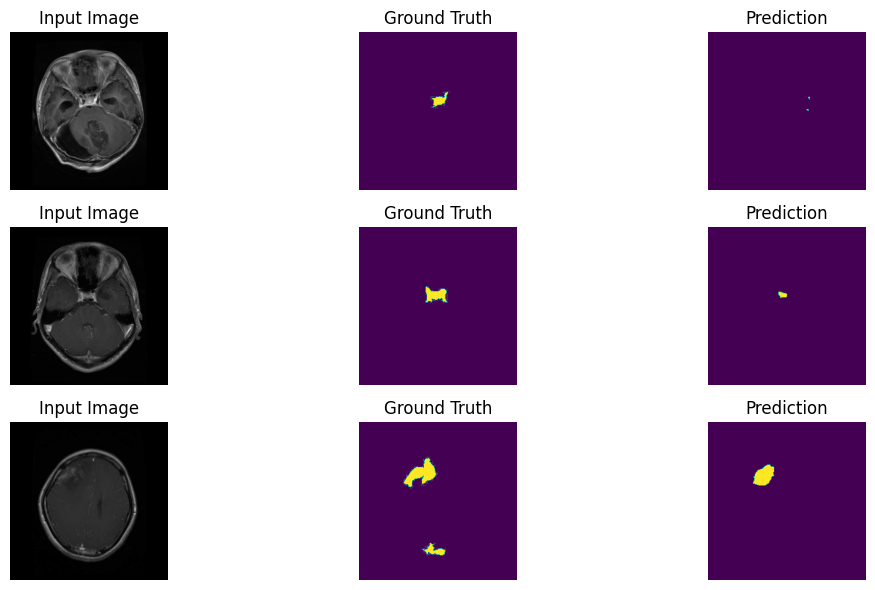

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Multi-class IoU & Dice ---
def multiclass_iou(y_true, y_pred, num_classes):
    ious = []
    for c in range(num_classes):
        y_true_c = tf.cast(y_true == c, tf.float32)
        y_pred_c = tf.cast(y_pred == c, tf.float32)

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection
        iou = (intersection + 1e-7) / (union + 1e-7)
        ious.append(iou.numpy())
    return ious, np.mean(ious)

def multiclass_dice(y_true, y_pred, num_classes):
    dices = []
    for c in range(num_classes):
        y_true_c = tf.cast(y_true == c, tf.float32)
        y_pred_c = tf.cast(y_pred == c, tf.float32)

        intersection = 2.0 * tf.reduce_sum(y_true_c * y_pred_c)
        denominator = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c)
        dice = (intersection + 1e-7) / (denominator + 1e-7)
        dices.append(dice.numpy())
    return dices, np.mean(dices)

# --- Run evaluation on test set ---
all_ious, all_dices = [], []
num_classes = 21  # adjust if your dataset has a different number of classes

for images, masks in seg_test_ds.take(20):  # test on 20 batches for speed
    preds = unet_model.predict(images)
    preds = tf.argmax(preds, axis=-1)   # [batch, H, W]
    masks = tf.squeeze(masks, axis=-1)  # remove channel dim if present

    for y_true, y_pred in zip(masks, preds):
        ious, mean_iou = multiclass_iou(y_true, y_pred, num_classes)
        dices, mean_dice = multiclass_dice(y_true, y_pred, num_classes)
        all_ious.append(mean_iou)
        all_dices.append(mean_dice)

print(f"✅ Mean IoU over test set: {np.mean(all_ious):.4f}")
print(f"✅ Mean Dice over test set: {np.mean(all_dices):.4f}")

# --- Visualization (example with 3 samples) ---
for images, masks in seg_test_ds.take(1):
    preds = unet_model.predict(images)
    preds = tf.argmax(preds, axis=-1)

    plt.figure(figsize=(12, 6))
    for i in range(3):  # show 3 examples
        # Input Image
        plt.subplot(3, 3, i*3+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))   # ✅ rescale back
        plt.title("Input Image")
        plt.axis("off")

        # Ground Truth
        plt.subplot(3, 3, i*3+2)
        plt.imshow(masks[i].numpy(), cmap="viridis")            # ✅ colormap
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(3, 3, i*3+3)
        plt.imshow(preds[i].numpy(), cmap="viridis")            # ✅ colormap
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Step -10  Classification result 

In [17]:
from tensorflow.keras.models import load_model

# Load best checkpoint
best_unet = load_model("unet_seg_best.h5", compile=False)
best_unet.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Evaluate on test data
results = best_unet.evaluate(test_ds)
print("Test results:", results)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'unet_seg_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

#**Visualize Predictions (for  report)**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for imgs, masks in test_ds.take(1):  # take 1 batch
    preds = best_unet.predict(imgs)
    for i in range(3):  # show 3 examples
        plt.figure(figsize=(10,3))

        plt.subplot(1,3,1)
        plt.imshow(imgs[i].numpy())
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow((preds[i] > 0.5).astype("uint8").squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()


#  Plot Training History

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy Curve")
plt.show()


## Step 11 Define Classifier (with Transfer Learning)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def build_classifier(num_classes):
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = False  # freeze base model initially
    
    inputs = layers.Input(shape=(224,224,3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs, name="Classifier")
    return model


# Step 12 ====== CLASSIFICATION PIPELINE + TRAINING ======

In [ ]:
# ====== CLASSIFICATION PIPELINE + TRAINING ======

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import os

# --- Settings ---
CLASS_IMG_SIZE = (224, 224)
CLASS_BATCH_SIZE = 32 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.AUTOTUNE

# --- Dataset builder ---
def make_classification_dataset(data_dir, batch_size=CLASS_BATCH_SIZE, shuffle=True):
    raw_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",   # numeric labels
        image_size=CLASS_IMG_SIZE,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED
    )
    class_names = raw_ds.class_names  # capture class names
    
    # normalize images
    ds = raw_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds, class_names

# --- Build datasets ---
train_cls_ds, class_names = make_classification_dataset(CLS_TRAIN, shuffle=True)
test_cls_ds, _ = make_classification_dataset(CLS_TEST, shuffle=False)

num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Class names:", class_names)

# --- Build classifier model ---
def build_classifier(num_classes):
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = False  # freeze for transfer learning
    
    inputs = layers.Input(shape=(224,224,3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = models.Model(inputs, outputs, name="Classifier")
    return model

# --- Compile inside strategy.scope() ---
with strategy.scope():
    classifier_model = build_classifier(num_classes)
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

classifier_model.summary()

# --- Callbacks ---
checkpoint_cb_cls = tf.keras.callbacks.ModelCheckpoint(
    "classifier_best.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop_cb_cls = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True
)

# --- Train ---
history_cls = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=15,
    callbacks=[checkpoint_cb_cls, earlystop_cb_cls]
)

# --- Evaluate ---
best_classifier = tf.keras.models.load_model("classifier_best.h5")
results_cls = best_classifier.evaluate(test_cls_ds)
print("Classifier Test Results:", results_cls)


New 

# Step 13  ====== BEST CLASSIFIER PIPELINE ======

In [ ]:
# ====== BEST CLASSIFIER PIPELINE ======

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# --- Settings ---
CLASS_IMG_SIZE = (224, 224)
CLASS_BATCH_SIZE = 32 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.AUTOTUNE

# --- Data augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# --- Dataset builder ---
def make_classification_dataset(data_dir, batch_size=CLASS_BATCH_SIZE, shuffle=True):
    raw_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        image_size=CLASS_IMG_SIZE,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED
    )
    class_names = raw_ds.class_names
    
    ds = raw_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.prefetch(AUTOTUNE)
    return ds, class_names

# --- Build datasets ---
train_cls_ds, class_names = make_classification_dataset(CLS_TRAIN, shuffle=True)
test_cls_ds, test_class_names = make_classification_dataset(CLS_TEST, shuffle=False)

# --- Check class consistency ---
print("Train classes:", class_names)
print("Test classes:", test_class_names)

if class_names != test_class_names:
    print("⚠️ WARNING: Train and test class names differ! This may cause 0% val accuracy.")

num_classes = len(class_names)
print("Number of classes:", num_classes)

# --- Build classifier model ---
def build_classifier(num_classes, trainable_backbone=False):
    base_model = EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = trainable_backbone  # freeze or unfreeze backbone
    
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=trainable_backbone)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs, name="Classifier")

# --- Stage 1: Train with frozen backbone ---
with strategy.scope():
    classifier_model = build_classifier(num_classes, trainable_backbone=False)
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

checkpoint_cb_cls = tf.keras.callbacks.ModelCheckpoint(
    "classifier_best.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop_cb_cls = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True
)

history_stage1 = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=10,
    callbacks=[checkpoint_cb_cls, earlystop_cb_cls]
)

# --- Stage 2: Fine-tune deeper layers ---
with strategy.scope():
    base_model = classifier_model.layers[2]  # EfficientNet backbone
    base_model.trainable = True
    
    # freeze only first ~100 layers (early conv filters)
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR for fine-tuning
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

history_stage2 = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=10,
    callbacks=[checkpoint_cb_cls, earlystop_cb_cls]
)

# --- Evaluate best model ---
best_classifier = tf.keras.models.load_model("classifier_best.h5")
results_cls = best_classifier.evaluate(test_cls_ds)
print("✅ Final Classifier Test Results:", results_cls)


# Step 14 

In [ ]:
import os

# Define dataset paths (adjust if needed)
CLASSIFICATION_PATH = "/kaggle/input/brisc2025/brisc2025/classification_task"
CLS_TRAIN = os.path.join(CLASSIFICATION_PATH, "train")
CLS_TEST  = os.path.join(CLASSIFICATION_PATH, "test")

def count_images_per_class(path):
    counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len(os.listdir(cls_path))
    return counts

print("Train distribution:", count_images_per_class(CLS_TRAIN))
print("Test distribution:", count_images_per_class(CLS_TEST))


# Step 15  Try 3


In [ ]:
# Step 15 ====== CLASSIFICATION WITH RESNET50 + AUGMENTATION ======

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

# --- Data Augmentation applied to dataset ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    layers.RandomRotation(0.1),
])

def augment_image(image, label):
    image = data_augmentation(image)
    return image, label

# Apply augmentation ONLY to training set
train_cls_ds = train_cls_ds.map(augment_image, num_parallel_calls=AUTOTUNE)

# --- Build Classifier ---
def build_resnet_classifier(num_classes, trainable_backbone=False):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = trainable_backbone  # freeze or unfreeze
    
    inputs = layers.Input(shape=(224,224,3))
    x = base_model(inputs, training=trainable_backbone)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs, name="ResNetClassifier")

# --- Stage 1 Training (freeze backbone) ---
with strategy.scope():
    classifier_model = build_resnet_classifier(num_classes, trainable_backbone=False)
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "classifier_best.weights.h5",   # <-- fixed name
    save_best_only=True,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history_stage1 = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=8,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr],
    class_weight=class_weights
)

# --- Load Best Weights ---
classifier_model.load_weights("classifier_best.weights.h5")

# --- Stage 2 Fine-Tuning (unfreeze deeper layers) ---
with strategy.scope():
    base_model = classifier_model.layers[1]  # ResNet backbone
    base_model.trainable = True
    for layer in base_model.layers[:100]:  # keep early layers frozen
        layer.trainable = False
    
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

history_stage2 = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr],
    class_weight=class_weights
)

# --- Final Evaluation ---
classifier_model.load_weights("classifier_best.weights.h5")
results_cls = classifier_model.evaluate(test_cls_ds)
print("✅ Final Classifier Test Results:", results_cls)


In [ ]:
# Step 16 ====== CLASSIFICATION EVALUATION ======

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Collect predictions ---
y_true = []
y_pred = []

for images, labels in test_cls_ds:
    preds = classifier_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
# ======================================================
# STEP 15 - FINAL CLASSIFIER (ResNet50 + Regularization)
# ======================================================

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.utils import class_weight
import numpy as np, os, random

# --- Global Seed ---
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# --- Settings ---
CLASS_IMG_SIZE = (224, 224)
CLASS_BATCH_SIZE = 32 * strategy.num_replicas_in_sync
AUTOTUNE = tf.data.AUTOTUNE

# --- Data Augmentation ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
])

# --- Dataset Builder ---
def make_classification_dataset(data_dir, batch_size=CLASS_BATCH_SIZE, shuffle=True):
    raw_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        image_size=CLASS_IMG_SIZE,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED
    )
    class_names = raw_ds.class_names
    ds = raw_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE), class_names

# --- Paths ---
CLASSIFICATION_PATH = "/kaggle/input/brisc2025/brisc2025/classification_task"
CLS_TRAIN = os.path.join(CLASSIFICATION_PATH, "train")
CLS_TEST  = os.path.join(CLASSIFICATION_PATH, "test")

# --- Build datasets ---
train_cls_ds, class_names = make_classification_dataset(CLS_TRAIN, shuffle=True)
test_cls_ds, _ = make_classification_dataset(CLS_TEST, shuffle=False)

num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Class names:", class_names)

# --- Compute class weights ---
train_counts = {cls: len(os.listdir(os.path.join(CLS_TRAIN, cls))) for cls in class_names}
y_train = []
for cls, n in train_counts.items():
    y_train.extend([class_names.index(cls)] * n)
y_train = np.array(y_train)

weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# --- Build Classifier ---
def build_resnet_classifier(num_classes, trainable_backbone=False):
    base_model = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224,224,3)
    )
    base_model.trainable = trainable_backbone
    
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=trainable_backbone)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)   # stronger dropout
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inputs, outputs, name="ResNetClassifier")

# --- Stage 1: Frozen backbone ---
with strategy.scope():
    classifier_model = build_resnet_classifier(num_classes, trainable_backbone=False)
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-5),   # lower LR for stability
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "classifier_best.h5", save_best_only=True, monitor="val_accuracy", mode="max"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

history_stage1 = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=8,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr],
    class_weight=class_weights
)

# --- Stage 2: Fine-tune deeper layers ---
with strategy.scope():
    base_model = classifier_model.layers[2]  # ResNet backbone
    base_model.trainable = True
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

history_stage2 = classifier_model.fit(
    train_cls_ds,
    validation_data=test_cls_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr],
    class_weight=class_weights
)

# --- Evaluate ---
best_classifier = tf.keras.models.load_model("classifier_best.h5")
results_cls = best_classifier.evaluate(test_cls_ds)
print("✅ Final Classifier Test Results:", results_cls)
